# Battleship solver

In [ ]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister

## Oracle definition

### Increment and decrement gates

In [ ]:
def increment_gate(N: int) -> qiskit.circuit.Gate:
    """Returns a register-increment gate for size N.

    Parameters:
        N (int): Register size to implement.
    """
    
    count = QuantumRegister(N)
    c = QuantumCircuit(count, name="increment")

    for i in range(N-1, 0, -1):
        c.mcx(count[:i], count[i])
    
    c.x(count[0])

    return c.to_gate(label="increment")


def decrement_gate(N: int) -> qiskit.circuit.Gate:
    """Returns a register-decrement gate for size N. 

    Parameters:
        N (int): Register size to implement.
    """

    decrement = increment_gate(N).inverse().copy(name="decrement")
    return decrement


# Example of increment gate.
nbits = 3
count = QuantumRegister(nbits, name="counting_register")
control = QuantumRegister(1, name="control")
example = QuantumCircuit(count,control)
example.append(increment_gate(count.size).control(1), [*control, *count])
example_inc = example.draw('text')


# Example of decrement gate.
nbits = 3
count = QuantumRegister(nbits, name="counting_register")
control = QuantumRegister(1, name="control")
example = QuantumCircuit(count,control)
example.append(decrement_gate(count.size).control(1), [*control, *count])
example_dec = example.draw('text')

print(example_inc)
print(example_dec)

                     ┌────────────┐
counting_register_0: ┤0           ├
                     │            │
counting_register_1: ┤1 increment ├
                     │            │
counting_register_2: ┤2           ├
                     └─────┬──────┘
            control: ──────■───────
                                   
                     ┌────────────┐
counting_register_0: ┤0           ├
                     │            │
counting_register_1: ┤1 decrement ├
                     │            │
counting_register_2: ┤2           ├
                     └─────┬──────┘
            control: ──────■───────
                                   


### Check count gate

In [ ]:
def check_count_gate(rows: [int], cols: [int], mapped_board, initial_board, board: QuantumRegister, count: QuantumRegister, rowcol_correct: QuantumRegister):
    """Returns a gate that performs a check on the number of qubits in state |1> on each row and column 

    Parameters:
        rows ([int]): Array with expected number of ships on each row.
        cols ([int]): Array with expected number of columns on each row.
        mapped_board: a dictionary that maps cells (i,j) to a qubit in a qubit register.
        initial_board: a dictionary that maps cells (i,j) to a qubit in a qubit register.
        board: Quantum register with qubits for representing the board.
        count: Quantum register for keeping track of the number of ships.
        rowcol_correct: Quantum register for keeping track of row and columns that comply to the condition.
    """
    
    c = QuantumCircuit(board, count, rowcol_correct, name="count_gate")

    N = len(rows)
    M = len(cols)

    for i in range(len(rows)):
        temp_num = rows[i]
        # Count the 1s in the current column.
        for j in range(M):
            if initial_board[i][j] == 1: # ship
                temp_num -= 1
            elif initial_board[i][j] == 0:
                c.append(
                    increment_gate(count.size).control(1), [mapped_board[(i, j)], *count]
                )

        # Represent the current column-tally number in binary.
        cur_number = bin(temp_num)[2:]
        # Append 0s to the beggining if necessary.
        cur_number = (count.size - len(cur_number)) * "0" + cur_number
        # Flip 1s to 0s and 0s to 1s.
        cur_number = cur_number.replace("1", "2").replace("0", "1").replace("2", "0")[::-1]

        # XOR the count register based on cur_number.
        for ind, el in enumerate(cur_number):
            if el == "1":
                c.x(count[ind])

        # If every qubit in count is 1, then set rowcol_correct[i] to 1.
        c.mcx(count, rowcol_correct[i])

        # Undo XOR.
        for ind, el in enumerate(cur_number):
            if el == "1":
                c.x(count[ind])

        # Clear counter.
        for j in range(M):
            if initial_board[i][j] == 0:
                c.append(
                    decrement_gate(count.size).control(1), [mapped_board[(i,j)], *count]
                )
        

    for i in range(len(cols)):
        temp_num = cols[i]
        for j in range(N):
            if initial_board[j][i] == 1: # ship
                temp_num -= 1
            elif initial_board[j][i] == 0:
                c.append(
                    increment_gate(count.size).control(1), [mapped_board[(j,i)], *count]
                )

        # Represent the current column-tally number in binary.
        cur_number = bin(temp_num)[2:]
        # Append 0s to the beggining if necessary.
        cur_number = (count.size - len(cur_number)) * "0" + cur_number
        # Flip 1s to 0s and 0s to 1s.
        cur_number = cur_number.replace("1", "2").replace("0", "1").replace("2", "0")[::-1]

        # XOR the count register based on cur_number.
        for ind, el in enumerate(cur_number):
            if el == "1":
                c.x(count[ind])

        # If every qubit in count is 1, then set rowcol_correct[i] to 1.
        c.mcx(count, rowcol_correct[i + len(rows)])

        # Undo XOR.
        for ind, el in enumerate(cur_number):
            if el == "1":
                c.x(count[ind])

        # Clear counter.
        for j in range(N):
            if initial_board[j][i] == 0:
                c.append(
                    decrement_gate(count.size).control(1), [mapped_board[(j,i)], *count]
                )

    return c.to_gate()    

### Check ships touching gate

In [ ]:
def check_ships_touching_gate(N: int, M: int, mapped_board, initial_board, board:QuantumRegister, diagonal_elements:QuantumRegister,
diagonal_correct:QuantumRegister):
    """Returns a gate that performs a check on the no ships touching condition 

    Parameters:
        N (int): Integer representing number of rows.
        M (int): Integer representing number of columns.
        mapped_board: a dictionary that maps cells (i,j) to a qubit in a qubit register.
        initial_board (array of array of ints): 2d array that stores the initial board as three type of cells(water=-1, empty=0, ship=1)
        board: Quantum register with qubits for representing the board.
        diagonal_elements: Quantum register for keeping track of elements on the current diagonal.
        diagonal_correct: Quantum register for keeping track of diagonals that comply to the condition.
    """

    c = QuantumCircuit(board, diagonal_elements, diagonal_correct, name="check_touching")
    # now check whether some ships are touching

    #def get_cell(row: int, coll: int, cells_per_row: int) -> int:
        
    #    return row*cells_per_row+coll

    # Top-right beginning of every k-anti-diagonal. (https://math.stackexchange.com/questions/227345/name-for-diagonals-of-a-matrix)
    off_diagonal = [(0, i) for i in range(1, M)] + [(i, M - 1) for i in range(1, N-1)]
    Z = 0

    #print(mapped_board[(0, 0)])

    def mixed_mcx(rc1, rc2, K):
        f1 = int(initial_board[rc1[0]][rc1[1]])
        f2 = int(initial_board[rc2[0]][rc2[1]])

        if f1 == -1 or f2 == -1: # if either of them is known to be water
            return
        elif f1 == 0 and f2 == 0:
            c.mcx(mapped_board[rc1], mapped_board[rc2], diagonal_elements[K])
        elif f1 == 1:
            c.cx(mapped_board[rc2], diagonal_elements[K])
        else:
            c.cx(mapped_board[rc1], diagonal_elements[K])

    # k-anti-diagonals.
    for (start_X, start_Y) in off_diagonal:
        cur_X = start_X
        cur_Y = start_Y
        K = 0

        # Store the AND between every two consecutive qubits on the current diagonal.
        while cur_Y != 0 and cur_X != N-1:
            #c.mcx([mapped_board[(cur_X, cur_Y)], mapped_board[(cur_X+1, cur_Y-1)]], diagonal_elements[K])
            mixed_mcx((cur_X, cur_Y), (cur_X+1, cur_Y-1), K)
            K += 1

            cur_X += 1
            cur_Y -= 1

        # Negate all of them.
        c.x(diagonal_elements[:K])

        c.mcx(diagonal_elements[:K], diagonal_correct[Z])

        # Reset negation.
        c.x(diagonal_elements[:K])

        cur_X = start_X
        cur_Y = start_Y
        K = 0

        # Reset diagonal array.
        while cur_Y != 0 and cur_X != N-1:
            #c.mcx([mapped_board[(cur_X, cur_Y)], mapped_board[(cur_X+1, cur_Y-1)]], diagonal_elements[K])
            mixed_mcx((cur_X, cur_Y), (cur_X+1, cur_Y-1), K)
            K += 1

            cur_X += 1
            cur_Y -= 1
        Z += 1    

    # Top-left beginning of k-diagonals.
    main_diagonal = [(0, i) for i in range(0, M-1)] + [(i, 0) for i in range(1, N-1)]

    # main-diagonal
    for (start_X, start_Y) in main_diagonal:
        cur_X = start_X
        cur_Y = start_Y
        K = 0

        # store the AND between every two consecutive qubits on the current diagonal
        while cur_Y != M-1 and cur_X != N-1:
            #c.mcx([mapped_board[(cur_X, cur_Y)], mapped_board[(cur_X+1, cur_Y+1)]], diagonal_elements[K])
            mixed_mcx((cur_X, cur_Y), (cur_X+1, cur_Y+1), K)
            K += 1

            cur_X += 1
            cur_Y += 1

        # negate all of them 
        c.x(diagonal_elements[:K])

        # store the check into diagonal register
        c.mcx(diagonal_elements[:K], diagonal_correct[Z])

        # reset negation
        c.x(diagonal_elements[:K])

        cur_X = start_X
        cur_Y = start_Y
        K = 0

        # reset diagonal array 
        while cur_Y != M-1 and cur_X != N-1:
            #c.mcx([mapped_board[(cur_X, cur_Y)], mapped_board[(cur_X+1, cur_Y+1)]], diagonal_elements[K])
            mixed_mcx((cur_X, cur_Y), (cur_X+1, cur_Y+1), K)
            K += 1

            cur_X += 1
            cur_Y += 1

        Z += 1

    return c.to_gate()


### Board check gate

In [ ]:
def board_check_gate(
    rows: [int],
    cols: [int],
    mapped_board,
    initial_board,
    board: QuantumRegister,
    check_qubits: QuantumRegister,
    working_qubits: QuantumRegister,
) -> qiskit.circuit.Gate:
    """Returns the oracle which should answer if a trial solution is correct or not.

    Parameters:
        rows (array of ints): Array with the number of 1s we want to see in each row.
        cols (array of ints): Array with the number of 1s we want to see in each coll.
        mapped_board: a dictionary that maps cells (i,j) to a qubit in a qubit register.
        initial_board (array of array of ints): 2d array that stores the initial board as three type of cells(water=-1, empty=0, ship=1)
        board: Quantum register with qubits for representing the board.
        check_qubits (QuantumRegister): Quantum register we use to keep track of the two conditions.
        working_qubits (QuantumRegister): Quantum register that holds all qubits we will need for the execution of the oracle.

    Returns:
        Oracle (Gate)
    """

    # Suppose the board is in the following format
    # 0    1   2   3 4 ..  m
    # m+1 m+2 m+3 ....... 2*m
    # ...
    # ..
    # .......................

    oracle = QuantumCircuit(board, check_qubits, working_qubits, name="board_check")
    N = len(rows)
    M = len(cols)
    COUNT_N = int(np.ceil(np.log2(max(N, M)))) + 1

    count = QuantumRegister(bits=[*working_qubits[:COUNT_N]], name="count bits")
    rowcol_correct = QuantumRegister(bits=[*working_qubits[COUNT_N:COUNT_N+N+M]], name="keep row and coll bits")

    count_gate_defined = check_count_gate(rows, cols, mapped_board, initial_board, board, count, rowcol_correct)
    oracle.append(count_gate_defined, [*board, *count, *rowcol_correct])

    # store check of all rows/cols
    oracle.mcx(rowcol_correct, check_qubits[0])

    oracle.append(count_gate_defined.inverse().copy(name="count_gate_inverse"), [*board, *count, *rowcol_correct])

    # ships touching check

    diagonal_elements = QuantumRegister(bits=[*working_qubits[:min(N-1, M-1)]])
    diagonal_correct = QuantumRegister(bits=[*working_qubits[diagonal_elements.size: diagonal_elements.size+2*N+2*M-6]])

    touching_gate_defined = check_ships_touching_gate(N, M, mapped_board, initial_board, board, diagonal_elements, diagonal_correct)

    oracle.append(touching_gate_defined, [*board, *diagonal_elements, *diagonal_correct])

    oracle.mcx(diagonal_correct, check_qubits[1])

    oracle.append(touching_gate_defined.inverse().copy(name="check_touching_inverse"), [*board, *diagonal_elements, *diagonal_correct])

    return oracle.to_gate()

### Oracle gate

In [ ]:
def oracle_gate(rows: [int], cols: [int], mapped_board, initial_board, board: QuantumRegister, a: QuantumRegister, helper_qubits: QuantumRegister):
    """Returns the oracle which should answer if a trial solution is correct or not.

    Parameters:
        rows (array of ints): Array with the number of 1s we want to see in each row.
        cols (array of ints): Array with the number of 1s we want to see in each coll.
        mapped_board: a dictionary that maps cells (i,j) to a qubit in a qubit register.
        initial_board (array of array of ints): 2d array that stores the initial board as three type of cells(water=-1, empty=0, ship=1)
        board: Quantum register with qubits for representing the board.
        a (QuantumRegister): Quantum register that signifies if the current solution is a correct one.
        helper_qubits (QuantumRegister): Quantum register that holds all qubits we will need for the execution of the oracle.
    Returns:
        Oracle (Gate)
    """
    
    check_qubits = QuantumRegister(bits=helper_qubits[:2], name="check_qubits")
    working_qubits = QuantumRegister(bits=helper_qubits[2:], name="working_bits")
    
    oracle = QuantumCircuit(board, a, check_qubits, working_qubits, name="oracle")

    # Do full board check.
    board_check_gate_def = board_check_gate(rows, cols, mapped_board, initial_board, board, check_qubits, working_qubits)
    oracle.append(
        board_check_gate_def, [*board, *check_qubits, *working_qubits]
    )

    # Apply phase flip.
    oracle.x(a)
    oracle.h(a)
    oracle.mcx(check_qubits, a)
    oracle.h(a)
    oracle.x(a)

    # Undo operations.
    oracle.append(
        board_check_gate_def.inverse(), [*board, *check_qubits, *working_qubits]
    )
    
    return oracle.to_gate()

## Grover diffusion operator definition

/root/venv/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


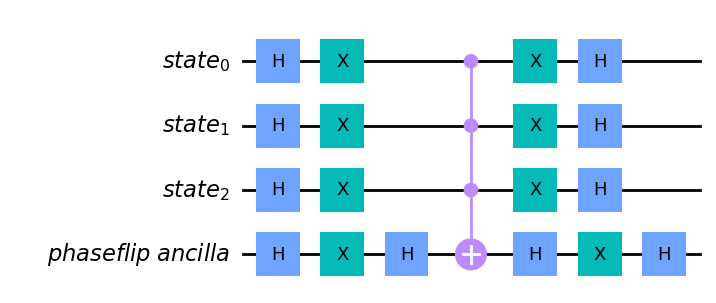

In [ ]:
def grover_operator(num_qubits: int) -> qiskit.circuit.Gate:
    qubits = QuantumRegister(num_qubits)
    grover = QuantumCircuit(qubits, name="Grover Diffusion")

    grover.h(qubits)
    grover.x(qubits)
    grover.h(qubits[-1])
    grover.mcx(qubits[:-1], qubits[-1])
    grover.h(qubits[-1])
    grover.x(qubits)
    grover.h(qubits)

    return grover.to_gate()

# Example
example_q = QuantumRegister(3, name="state")
example_a = AncillaRegister(1, name="phaseflip ancilla")
example = QuantumCircuit(example_q,example_a)
example.append(grover_operator(4), [*example_q, *example_a])
#example.draw('mpl')
example.decompose().draw('mpl')

## Total circuit

In [ ]:
def prepare_board(rows, cols):
    """Returns a pair of 2d array of the board and the number of cells we can deduce the values of.

    Parameters:
        rows (array of ints): Array with the number of 1s we want to see in each row.
        cols (array of ints): Array with the number of 1s we want to see in each coll.
    Returns:
        (2D array of ints, int)
    """

    N=len(rows)
    M=len(cols)
    mxN=N*M+N+M+2
    source = mxN - 2
    sink = mxN - 1

    matrix = [[0] * mxN for i in range(mxN)]
    lvl = [0] * mxN

    def bfs():
        q = []

        for i in range(mxN):
            lvl[i] = -1
        
        lvl[source] = 0
        q.append(source)

        while len(q) > 0:
            v = q.pop()

            for i in range(mxN):
                if matrix[v][i] > 0 and lvl[i] == -1:
                    q.append(i)
                    lvl[i] = lvl[v] + 1
        return lvl[sink] != -1

    def dfs(v, flow):
        if v == sink:
            return flow
        for i in range(mxN):
            if matrix[v][i] > 0 and lvl[v] + 1 == lvl[i]:
                tmp = dfs(i, min(flow, matrix[v][i]))
                if tmp > 0:
                    matrix[v][i] -= tmp
                    matrix[i][v] += tmp

                    return tmp
        return 0

    def solve():
        delta = 0
        ans = 0
        INF = 1e9
        while bfs():
            delta = dfs(source, INF)
            while delta != 0:
                ans += delta

                delta = dfs(source, INF)

        return ans

    def restore_matrix():
        for i in range(mxN):
            lvl[i] = 0
            for j in range(mxN):
                matrix[i][j] = 0

        for i in range(N):
            matrix[source][i] = rows[i]
        for i in range(M):
            matrix[i + N][sink] = cols[i]
        for i in range(N):
            for j in range(M):
                matrix[i][N+M+i*M+j] = 1

                matrix[N+M+i*M+j][j+N] = 1

    def check_cell():
        restore_matrix()
        orig_answer = solve()

        board = np.zeros((len(rows),len(cols)))
        K = 0

        for i in range(N):
            for j in range(M):
                if rows[i] == 0 or cols[j] == 0:
                    board[i][j] = -1
                    K += 1
                    continue
                # make a cell always 0

                rows[i] -= 1
                cols[j] -= 1

                restore_matrix()

                matrix[i][N+M+i*M+j] = 0
                matrix[N+M+i*M+j][j+N] = 0

                # run maxflow

                new_ans = solve()

                rows[i] += 1
                cols[j] += 1

                if (new_ans + 1 != orig_answer):
                    board[i][j] = -1
                    K += 1

        for i in range(N):
            for j in range(M):
                if rows[i] == 0 or cols[j] == 0:
                    continue
                restore_matrix()

                matrix[i][N+M+i*M+j] = 0
                matrix[N+M+i*M+j][j+N] = 0

                new_ans = solve()

                if (new_ans != orig_answer):
                    board[i][j] = 1
                    K += 1
        
        return (board, K)
        
    return check_cell()    

In [ ]:
def print_solution(result, used_qubits, rows, cols, initial_board):
    """Prints the final solution that complies to the rows/cols arrays and the no touching condition. 

    Parameters:
        result (SimulatorResult): Result returned from the ibm simulator
        used_qubits (Int): Number of qubits we have used for the board.
        rows (array of ints): Array with the number of 1s we want to see in each row.
        cols (array of ints): Array with the number of 1s we want to see in each coll.s(water=-1, empty=0, ship=1)
        initial_board (array of array of ints): 2d array that stores the initial board as three type of cells(water=-1, empty=0, ship=1)
   Returns:
        
    """

    print(f"rows = {rows}")
    print(f"cols = {cols}")

    solution = ""

    if used_qubits == 0:
        solution = ""
    else:
        solution = max(result.quasi_dists[0], key=result.quasi_dists[0].get)
        solution = bin(solution)[2:]
        solution = (used_qubits - len(solution)) * "0" + solution
        solution = solution[::-1]

    print(f"Qubits states = {solution}")

    print("\nBoard:")

    # Print col numbers
    print("  | ", end="")
    for col in cols:
        print(f"{col} | ", end="")

    print("\n--|" + "-"*(4*len(cols)))

    K = 0

    for i, row in enumerate(rows):
        solution_row = ""

        for j in range(M):
            if initial_board[i][j] == -1:
                solution_row += "0   "
            elif initial_board[i][j] == 1:
                solution_row += "1   "
            else:
                solution_row += solution[K] + "   "
                K += 1

        print(f"{row} | " + solution_row)

### Final setup

In [ ]:
# Problem setup
rows = [3, 0, 3]
cols = [2, 1, 2, 1]

# -1 = water
#  0 = empty
#  1 = ship
initial_board, taken_cells = prepare_board(rows, cols) #np.zeros((len(rows),len(cols)))

print(taken_cells)

if taken_cells == len(rows) * len(cols):
    print ("Only one solution possible")
    print_solution({}, 0, rows, cols, initial_board)
else:
    N = len(rows)
    M = len(cols)
    COUNT_N = int(np.ceil(np.log2(max(N, M)))) + 1
    n_helper_bits = max(COUNT_N+N+M, 2*N+2*M+min(N-1,M-1)-6)+2

    print(f"number of saved qubits = {taken_cells}")
    print (initial_board)

    # Circuit setup
    board = QuantumRegister(N*M-taken_cells, name="board")

    a = QuantumRegister(1, name="phaseflip ancilla")
    helper_qubits = QuantumRegister(n_helper_bits, name="general ancilla")

    output = ClassicalRegister(N*M, name="solution")

    circuit = QuantumCircuit(board,a,helper_qubits,output)

    for i in range(board.size):
        circuit.h(board[i])

    mapped_board = {}
    K = 0
    for i in range(N):
        for j in range(M):
            if initial_board[i][j] == 0:
                mapped_board[(i, j)] = QuantumRegister(bits=[board[K]])
                K += 1

    # Ideal number of iterations.
    t = int(np.pi / 4 / np.arcsin(1 / (2**(board.size))**0.5) - 0.5)
    print(f"t = {t}")

    iteration = QuantumCircuit(board,a,helper_qubits,name="it")
    iteration.append(
        oracle_gate(rows, cols, mapped_board, initial_board, board, a, helper_qubits),
        [*board,*a,*helper_qubits]
    )
    iteration.append(
        grover_operator(board.size+1), [*board,*a]
    )
        
    circuit.compose(iteration.repeat(t), inplace=True)

    circuit.barrier()

    for (qbit, cbit) in zip(board,output):
        circuit.measure(qbit, cbit)

    print(f"number of total qubits = {circuit.num_qubits}")

    circuit.draw('mpl', plot_barriers=False)

8
number of saved qubits = 8
[[ 1.  0.  1.  0.]
 [-1. -1. -1. -1.]
 [ 1.  0.  1.  0.]]
t = 2
number of total qubits = 17


## Running on the IBM simulator backend

In [ ]:
# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='5d2bd56bca9ddbf7679ae688e8a161dc3b982e5cbeb227e3b94157831072b008efbc551f226f8db8b019241e53eeca1d2fdbfee3cd5d2bbbeb57eba433bbd746' # Timo's IBM API Token
)
backend = service.get_backend("simulator_mps")

from qiskit_ibm_runtime import Sampler

sampler = Sampler(backend)
job = sampler.run(circuit, shots=1024)

job.status()
result = job.result()

In [ ]:
print_solution(result, board.size, rows, cols, initial_board)

rows = [3, 0, 3]
cols = [2, 1, 2, 1]
Qubits states = 1001

Board:
  | 2 | 1 | 2 | 1 | 
--|----------------
3 | 1   1   1   0   
0 | 0   0   0   0   
3 | 1   0   1   1   


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f7dc926d-60cb-4400-9d30-82a530e8805b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>